In [1]:
%matplotlib nbagg

In [2]:
from qcodes.instrument.mock import MockInstrument
from qcodes.instrument.parameter import MultiParameter
import qcodes as qc
import numpy as np
import matplotlib.pyplot as plt
from qcodes.utils.helpers import is_sequence_of

In [3]:
class ExpandingAlazarArrayMultiParameter(MultiParameter):
    
    def __init__(self, name, names, labels, units, shapes, instrument, 
                 setpoints, setpoint_names, setpoint_labels, setpoint_units,
                 start, stop, step):
        self._start = start
        self._stop = stop
        self._step = step
        super().__init__(name,
                         names=names,
                         units=units, 
                         labels=labels,
                         shapes=shapes,
                         instrument=instrument,
                         setpoints=setpoints,
                         setpoint_names=setpoint_names,
                         setpoint_labels=setpoint_labels,
                         setpoint_units=setpoint_units)
        
    def set_setpoints_and_labels(self):
        arraysetpoints = (tuple(np.arange(self.start,self.stop,self.step)),)
        setpoints = [arraysetpoints]
        names = ['rawname']
        labels = ['rawlabel']
        setpoint_name = ('timename',)
        setpoint_names=[setpoint_name]
        setpoint_label = ('timelabel',)
        setpoint_labels=[setpoint_label]
        setpoint_unit = ('s',)
        setpoint_units = [setpoint_unit]
        units = ['v']
        shape = (len(arraysetpoints[0]),)
        shapes = [shape]
        for i, demod_freq in enumerate(self._instrument.demod_freqs):
            names.append("demod_freq_{}_name".format(i))
            labels.append("demod_freq_{}_label".format(i))
            units.append('v')
            shapes.append(shape)
            setpoints.append(arraysetpoints)
            setpoint_names.append(setpoint_name)
            setpoint_labels.append(setpoint_label)
            setpoint_units.append(setpoint_unit)
        self.names = tuple(names)
        self.labels = tuple(labels)
        self.units = tuple(units)
        self.shapes = tuple(shapes)
        self.setpoints = tuple(setpoints)
        self.setpoint_names = tuple(setpoint_names)
        self.setpoint_labels = tuple(setpoint_labels)
        self.setpoint_units = tuple(setpoint_units)
        
    def get(self):
        x = np.asarray(self.setpoints[0][0])
        y = np.zeros_like(x)
        arrays = [y]
        for demod_freq in self._instrument.demod_freqs:
            arrays.append(np.sin(demod_freq*x))
        return tuple(arrays)
    
    @property
    def start(self):
        return self._start
    
    @start.setter
    def start(self, value):
        self._start = value
        self.set_setpoints_and_labels()
        
    @property
    def step(self):
        return self._step
    
    @step.setter
    def step(self, value):
        self._step = value
        self.set_setpoints_and_labels()

    @property
    def stop(self):
        return self._stop
    
    @stop.setter
    def stop(self, value):
        self._stop = value
        self.set_setpoints_and_labels()

In [4]:
class MockAlazar(MockInstrument):
    
    
    def __init__(self, name='MyMockAlazar'):
        
        super().__init__(name, model=StupidModel())
        self.demod_freqs = []
        start=0
        stop=2*np.pi
        step=0.01
        setpoints = ((tuple(np.arange(start,stop,step)),),)
        self.add_parameter(name='acquisition',
                           names=('rawname',),
                           labels=('rawlabel',),
                           units=('v',),
                           shapes=((629,),),
                           setpoints=setpoints,
                           setpoint_names=(('timename',),),
                           setpoint_labels=(('timelabel',),),
                           setpoint_units=(('s',),),
                           start=start,
                           stop=stop,
                           step=step,
                           parameter_class=ExpandingAlazarArrayMultiParameter)
        
    def add_demodulator(self, demod_freq):
        if demod_freq not in self.demod_freqs:
            self.demod_freqs.append(demod_freq)
            self.acquisition.set_setpoints_and_labels()

    def remove_demodulator(self, demod_freq):
        if demod_freq in self.demod_freqs:
            self.demod_freqs.pop(self.demod_freqs.index(demod_freq))
            self.acquisition.set_setpoints_and_labels()

In [5]:
class StupidModel:
    """
    For reasons a MockInstument must have a model. 
    The aim of this model is to do exactly nothing
    """
    def write(self):
        pass
    
    def ask(self):
        pass
    

In [6]:
a = MockAlazar()

In [7]:
len(a.acquisition.setpoints[0][0])

629

In [8]:
data = qc.Measure(a.acquisition).run()

DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2017-02-21/#026_{name}_14-12-28'
   <Type>   | <array_id>           | <array.name> | <array.shape>
   Setpoint | timename_set         | timename     | (629,)
   Measured | MyMockAlazar_rawname | rawname      | (629,)
acquired at 2017-02-21 14:12:28


In [9]:
data.metadata['arrays']['MyMockAlazar_rawname']

{'__class__': 'qcodes.data.data_array.DataArray',
 'action_indices': (0, 0),
 'array_id': 'MyMockAlazar_rawname',
 'instrument': '__main__.MockAlazar',
 'instrument_name': 'MyMockAlazar',
 'is_setpoint': False,
 'label': 'rawlabel',
 'labels': ('rawlabel',),
 'name': 'rawname',
 'names': ('rawname',),
 'setpoint_labels': (('timelabel',),),
 'setpoint_names': (('timename',),),
 'shape': (629,),
 'unit': 'v',
 'units': ('v',)}

In [10]:
data.metadata['arrays']['timename_set']

{'__class__': 'qcodes.data.data_array.DataArray',
 'action_indices': (0,),
 'array_id': 'timename_set',
 'is_setpoint': True,
 'label': 'timelabel',
 'name': 'timename',
 'shape': (629,),
 'unit': 's'}

In [11]:
629*3

1887

In [23]:
a.add_demodulator(1)
a.add_demodulator(2)
a.add_demodulator(3)
a.acquisition.stop = 4*np.pi


In [24]:
data2 = qc.Measure(a.acquisition).run()

DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2017-02-21/#029_{name}_14-13-26'
   <Type>   | <array_id>                     | <array.name>      | <array.shape>
   Setpoint | timename_set                   | timename          | (1257,)
   Measured | MyMockAlazar_rawname           | rawname           | (1257,)
   Measured | MyMockAlazar_demod_freq_0_name | demod_freq_0_name | (1257,)
   Measured | MyMockAlazar_demod_freq_1_name | demod_freq_1_name | (1257,)
   Measured | MyMockAlazar_demod_freq_2_name | demod_freq_2_name | (1257,)
acquired at 2017-02-21 14:13:27


In [25]:
data2.metadata['arrays']['timename_set']

{'__class__': 'qcodes.data.data_array.DataArray',
 'action_indices': (0,),
 'array_id': 'timename_set',
 'is_setpoint': True,
 'label': 'timelabel',
 'name': 'timename',
 'shape': (1257,),
 'unit': 's'}

In [26]:
data2.metadata['arrays']['MyMockAlazar_demod_freq_0_name']

{'__class__': 'qcodes.data.data_array.DataArray',
 'action_indices': (0, 1),
 'array_id': 'MyMockAlazar_demod_freq_0_name',
 'instrument': '__main__.MockAlazar',
 'instrument_name': 'MyMockAlazar',
 'is_setpoint': False,
 'label': 'demod_freq_0_label',
 'labels': ('rawlabel',
  'demod_freq_0_label',
  'demod_freq_1_label',
  'demod_freq_2_label'),
 'name': 'demod_freq_0_name',
 'names': ('rawname',
  'demod_freq_0_name',
  'demod_freq_1_name',
  'demod_freq_2_name'),
 'setpoint_labels': (('timelabel',),
  ('timelabel',),
  ('timelabel',),
  ('timelabel',)),
 'setpoint_names': (('timename',),
  ('timename',),
  ('timename',),
  ('timename',)),
 'shape': (1257,),
 'unit': 'v',
 'units': ('v', 'v', 'v', 'v')}

<IPython.core.display.Javascript object>


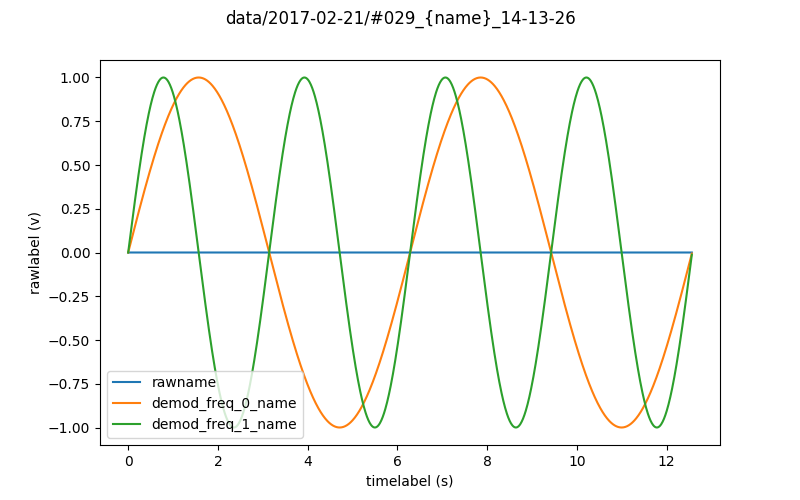

In [27]:
plot = qc.MatPlot()
plot.add(data2.MyMockAlazar_rawname)
plot.add(data2.MyMockAlazar_demod_freq_0_name)
plot.add(data2.MyMockAlazar_demod_freq_1_name)
#plot.add(data.MyMockAlazar_demod_freq_2_name)
plot.fig.axes[0].legend()

In [17]:
from toymodel import AModel, MockGates, MockSource, MockMeter, AverageGetter, AverageAndRaw

# now create this "experiment", note that all these are instruments 
model = AModel()
gates = MockGates('gates', model=model)
source = MockSource('source', model=model)
meter = MockMeter('meter', model=model)

In [18]:
data3 = qc.Loop(gates.chan0.sweep(0,1,num=2)).each(a.acquisition).run()

DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2017-02-21/#028_{name}_14-12-35'
   <Type>   | <array_id>                     | <array.name>      | <array.shape>
   Setpoint | gates_chan0_set                | chan0             | (2,)
   Setpoint | timename_set                   | timename          | (2, 629)
   Measured | MyMockAlazar_rawname           | rawname           | (2, 629)
   Measured | MyMockAlazar_demod_freq_0_name | demod_freq_0_name | (2, 629)
   Measured | MyMockAlazar_demod_freq_1_name | demod_freq_1_name | (2, 629)
   Measured | MyMockAlazar_demod_freq_2_name | demod_freq_2_name | (2, 629)
started at 2017-02-21 14:12:36


In [19]:
data3.metadata['arrays']['MyMockAlazar_rawname']

{'__class__': 'qcodes.data.data_array.DataArray',
 'action_indices': (0, 0),
 'array_id': 'MyMockAlazar_rawname',
 'instrument': '__main__.MockAlazar',
 'instrument_name': 'MyMockAlazar',
 'is_setpoint': False,
 'label': 'rawlabel',
 'labels': ('rawlabel',
  'demod_freq_0_label',
  'demod_freq_1_label',
  'demod_freq_2_label'),
 'name': 'rawname',
 'names': ('rawname',
  'demod_freq_0_name',
  'demod_freq_1_name',
  'demod_freq_2_name'),
 'setpoint_labels': (('timelabel',),
  ('timelabel',),
  ('timelabel',),
  ('timelabel',)),
 'setpoint_names': (('timename',),
  ('timename',),
  ('timename',),
  ('timename',)),
 'shape': (2, 629),
 'unit': 'v',
 'units': ('v', 'v', 'v', 'v')}

In [20]:
data3.metadata['arrays']['timename_set']

{'__class__': 'qcodes.data.data_array.DataArray',
 'action_indices': (0,),
 'array_id': 'timename_set',
 'is_setpoint': True,
 'label': 'timelabel',
 'name': 'timename',
 'shape': (2, 629),
 'unit': 's'}

In [21]:
data3.metadata['arrays']['gates_chan0_set']

{'__class__': 'qcodes.data.data_array.DataArray',
 'action_indices': (),
 'array_id': 'gates_chan0_set',
 'instrument': 'toymodel.MockGates',
 'instrument_name': 'gates',
 'is_setpoint': True,
 'label': 'Gate Channel 0 (mV)',
 'name': 'chan0',
 'shape': (2,),
 'unit': '',
 'vals': '<Numbers -100<=v<=100>'}

In [22]:
data3.metadata['arrays']['timename_set']

{'__class__': 'qcodes.data.data_array.DataArray',
 'action_indices': (0,),
 'array_id': 'timename_set',
 'is_setpoint': True,
 'label': 'timelabel',
 'name': 'timename',
 'shape': (2, 629),
 'unit': 's'}